### Package and Data Imports

In [1]:
import scanpy as sc
from scipy.stats import spearmanr
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
import scipy as sp
import torch
import numpy as np
import pandas as pd

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostClassifier
from lightgbm.sklearn import LGBMClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

In [2]:
adata_nonsmkr = sc.read_text('data/internal_nonsmokerslung.expression.txt', delimiter='\t').T
adata_smkr = sc.read_text('data/internal_smokerslung.expression.txt', delimiter='\t').T

In [3]:
adata_nonsmkr.var_names

Index(['ACE2', 'TMPRSS2', 'IL6R', 'IL6ST', 'PCSK1', 'IL6', 'PCSK2', 'CTSE',
       'MYRF', 'MAG', 'MOG', 'MBP', 'PLP1', 'FURIN', 'PCSK4', 'PCSK5', 'PCSK6',
       'PCSK7', 'C1R', 'C2', 'C3', 'C5', 'CFI', 'CTSS', 'CTSL', 'CTSB',
       'CTSC'],
      dtype='object')

### Calculate Correlation Matrix

In [51]:
X = adata_nonsmkr.X
# corr_matrix_nonsmkr = np.corrcoef(X, rowvar=False) #pearson correlation
corr_matrix_nonsmkr, spearman_p_vals = spearmanr(X) #spearman correlation
X = adata_smkr.X
# corr_matrix_smkr = np.corrcoef(X, rowvar=False) #pearson correlation
corr_matrix_smkr, spearman_p_vals = spearmanr(X) #spearman correlation

corr_matrix_smkr

array([[ 1.00000000e+00,  5.00454777e-02,  2.51811820e-02,
         3.39153322e-02, -2.71424908e-03,  5.05733189e-03,
         7.48698807e-03,  1.48248897e-03,  3.98810389e-02,
         1.62095072e-04, -2.32415189e-03,  6.41279656e-02,
        -4.95403321e-04,  3.01592816e-02,  1.12629693e-02,
         2.75662037e-02,  1.38196936e-02,  4.07984476e-02,
         9.90450984e-04,  1.85797192e-02,  6.22884204e-02,
         2.03225454e-02,  3.29944145e-02,  6.48223825e-02,
         1.36667456e-02,  7.75633175e-02,  7.96191432e-02],
       [ 5.00454777e-02,  1.00000000e+00,  1.53637648e-01,
         1.77563590e-01, -8.86693904e-03, -2.75376381e-03,
         1.65671952e-01,  1.84972348e-01,  5.00921367e-02,
         1.57389134e-02,  9.35706394e-05,  9.94253720e-02,
        -2.31200809e-03,  1.24174824e-01,  4.58476474e-02,
         3.16434427e-02,  4.02124944e-02, -9.30026926e-03,
         7.25354227e-02,  3.81377426e-01,  3.48145052e-01,
         1.38132968e-01,  2.00752661e-01,  1.51742002e-

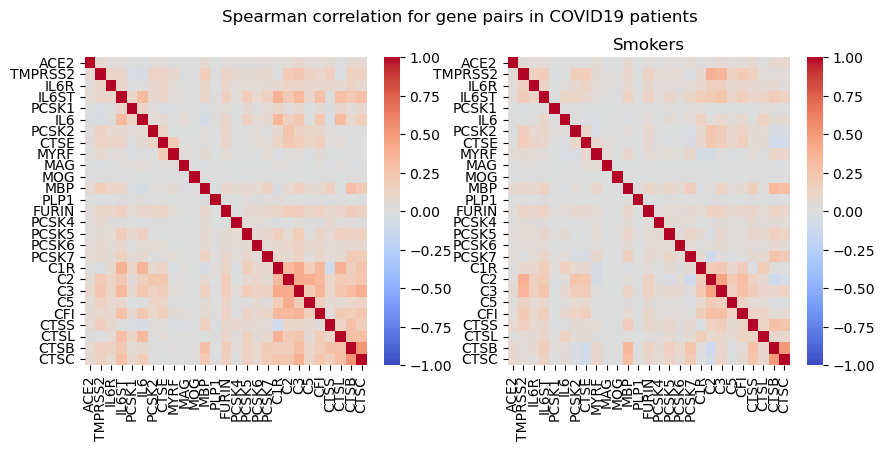

In [56]:
fig, axises = plt.subplots(ncols=2, figsize=(10, 4))
sns.heatmap(corr_matrix_nonsmkr, cmap='coolwarm', vmin=-1, vmax=1, ax=axises[0],
            xticklabels=adata_nonsmkr.var_names, yticklabels=adata_nonsmkr.var_names)
plt.title("Non-smokers")
sns.heatmap(corr_matrix_smkr, cmap='coolwarm', vmin=-1, vmax=1, ax=axises[1],
            xticklabels=adata_smkr.var_names, yticklabels=adata_smkr.var_names)
plt.title("Smokers")
plt.suptitle("Spearman correlation for gene pairs in COVID19 patients", fontsize=12, y=1.0)
plt.show()

### Calculate Mutual Information Matrix

In [22]:
X = adata_nonsmkr.X
num_feat = X.shape[1]
toStack = [[0 for i in range(num_feat)] for j in range(num_feat)]
for col in range(num_feat):
    toStack[col] = mutual_info_classif(X, X[:,col], n_neighbors=3)

27

In [24]:
mi_matrix = np.stack(toStack, axis=1)

<Axes: >

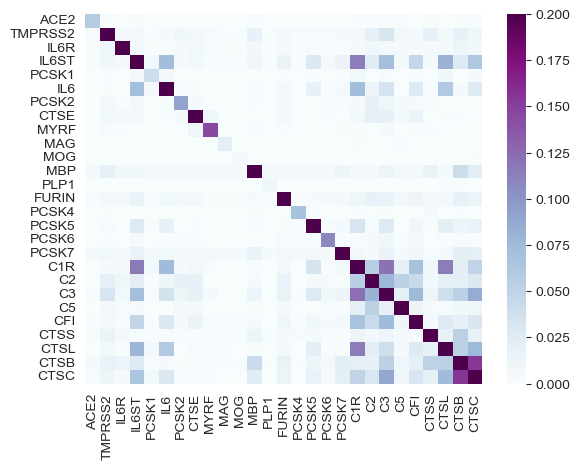

In [26]:
sns.heatmap(mi_matrix, cmap='BuPu', vmax=0.2,
            xticklabels=adata_smkr.var_names, yticklabels=adata_smkr.var_names)

### Random Forest Classifiers

###### create features X and target y

In [4]:
# pd.DataFrame(adata_smkr.X)
# sp.sparse.csr_matrix(adata_smkr.X)
X = np.concatenate([adata_nonsmkr.X, adata_smkr.X]) #combine ndarrays

In [5]:
print(f'# of non-smoker examples is {adata_nonsmkr.X.shape[0]} \n',
      f'# of smoker examples is {adata_smkr.X.shape[0]} \n',
      f'ratio is {adata_smkr.X.shape[0] / adata_nonsmkr.X.shape[0]}')

# of non-smoker examples is 277224 
 # of smoker examples is 96786 
 ratio is 0.3491256168297117


In [6]:
def make_target_from_two_datasets(matrix1: np.ndarray, matrix2: np.ndarray):
    y_1 = [False]*(adata_smkr.X.shape[0])
    y_2 = [True]*(adata_nonsmkr.X.shape[0])
    return np.concatenate([y_1, y_2])
y = make_target_from_two_datasets(adata_nonsmkr.X, adata_smkr)

In [7]:
# shuffle data and split (keeping target class proportions the same)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.6, shuffle=True, stratify=y)
# over-sample from the least frequent target class to balance the classes
randomOverSampler = RandomOverSampler()
X_train, y_train = randomOverSampler.fit_resample(X_train, y_train)
print(f'# of non-smoker training examples is {y_train[y_train==False].shape[0]} \n',
      f'# of smoker training examples is {y_train[y_train==True].shape[0]}')

# of non-smoker training examples is 110890 
 # of smoker training examples is 110890


In [9]:
# Hyperparameter Optimization
rf_grid_search = GridSearchCV(rf_model, n_jobs=-1, return_train_score=True, param_grid={
    'max_depth':    [1, 4, 8, 12, 16, 20, 24, 28, 32, 36, 40, 44],
    'n_estimators': [10]})
rf_grid_search.fit(X_train, y_train)
print(rf_grid_search.score(X_train, y_train))

0.8217061953287041


In [10]:
results = rf_grid_search.cv_results_
pd.DataFrame(results)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,1.624755,1.222527,0.090031,0.066118,1,10,"{'max_depth': 1, 'n_estimators': 10}",0.558098,0.568559,0.559654,...,0.565394,0.006524,12,0.561204,0.564766,0.558684,0.563064,0.575875,0.564718,0.005932
1,6.622455,0.711526,0.229794,0.055169,4,10,"{'max_depth': 4, 'n_estimators': 10}",0.584137,0.594756,0.599851,...,0.589643,0.007630,11,0.587756,0.595072,0.596588,0.581753,0.592259,0.590686,0.005384
2,7.827575,2.345804,0.155259,0.053447,8,10,"{'max_depth': 8, 'n_estimators': 10}",0.608621,0.607607,0.616850,...,0.614402,0.005652,10,0.619088,0.610881,0.615847,0.622892,0.620654,0.617872,0.004181
3,10.526849,1.539719,0.203972,0.071828,12,10,"{'max_depth': 12, 'n_estimators': 10}",0.630602,0.630828,0.641717,...,0.637492,0.005572,9,0.647094,0.646553,0.651051,0.651299,0.652719,0.649743,0.002457
4,10.472678,1.428550,0.204707,0.024566,16,10,"{'max_depth': 16, 'n_estimators': 10}",0.652178,0.655627,0.661466,...,0.658612,0.004049,8,0.682715,0.686029,0.678860,0.680122,0.683836,0.682312,0.002570
5,11.424119,0.791197,0.224761,0.032548,20,10,"{'max_depth': 20, 'n_estimators': 10}",0.675872,0.678420,0.693976,...,0.686491,0.007741,7,0.725077,0.725674,0.725184,0.723019,0.725032,0.724797,0.000918
6,11.574087,0.619141,0.331854,0.114156,24,10,"{'max_depth': 24, 'n_estimators': 10}",0.695599,0.697087,0.716250,...,0.706552,0.009002,6,0.758285,0.758003,0.759830,0.764547,0.754904,0.759114,0.003152
7,13.398638,1.898952,0.470952,0.186121,28,10,"{'max_depth': 28, 'n_estimators': 10}",0.716386,0.711313,0.736451,...,0.725967,0.010120,5,0.791663,0.789386,0.790750,0.792255,0.789995,0.790810,0.001050
8,14.017063,1.141789,0.370188,0.018833,32,10,"{'max_depth': 32, 'n_estimators': 10}",0.726463,0.722698,0.745762,...,0.736717,0.010001,4,0.810691,0.812393,0.808042,0.807247,0.808504,0.809375,0.001892
9,13.577063,1.299027,0.402723,0.056849,36,10,"{'max_depth': 36, 'n_estimators': 10}",0.729078,0.725471,0.749391,...,0.739986,0.010453,3,0.820740,0.819557,0.818080,0.817990,0.818773,0.819028,0.001025


In [11]:
def plot_cross_validation(param_list: list[int], mean_train_score: list[float], mean_validation_score: list[float]):
    fig, ax = plt.subplots()
    ax.plot(param_list, mean_train_score, "lightblue")
    ax.plot(param_list, mean_train_score, 'bo', label="training_score")
    ax.plot(param_list, mean_validation_score, "pink")
    ax.plot(param_list, mean_validation_score, 'ro', label="validation_score")
    ax.set_title('Random Forest Cross Validation Grid Search Results')
    ax.set_xlabel('Max Tree Depth')
    ax.set_ylabel('Mean Validation Score')
    ax.set_xticks(param_list)
    ax.legend()
    # plt.xlim(param_list[0], param_list[-1])
    plt.show()

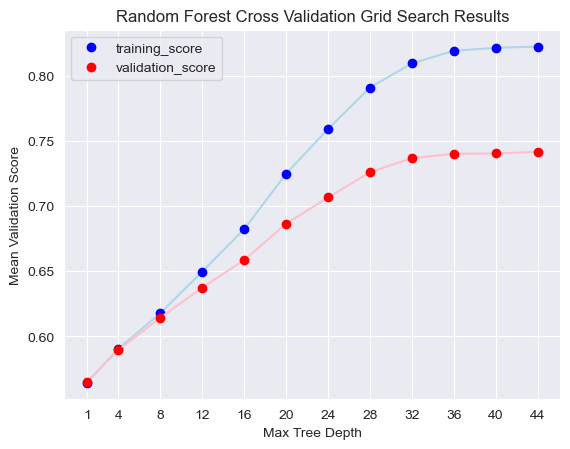

In [12]:
plot_cross_validation(results['param_max_depth'].tolist(), results['mean_train_score'].tolist(), results['mean_test_score'].tolist())

In [13]:
lgbmModel = LGBMClassifier()
catBoostModel = CatBoostClassifier(verbose=0)
xgbModel = XGBClassifier(eval_metric="logloss", verbosity=0)

tree_classifiers = {
    "random forest": rf_model,
    "LightGBM": lgbmModel,
    "CatBoost": catBoostModel,
    #"XGBoost": xgbModel,
}

In [41]:
# Hyperparameter Optimization
lgbm_grid_search = GridSearchCV(lgbmModel, n_jobs=-1, return_train_score=True, param_grid={
    'learning_rate': [0.1],
    'n_estimators': [100]
})
catboost_grid_search = GridSearchCV(catBoostModel, n_jobs=-1, return_train_score=True, param_grid={
    'learning_rate':    [1],
    'n_estimators': [1000]
})

In [29]:
lgbm_grid_search.fit(X_train, y_train)
print(lgbm_grid_search.score(X_train, y_train))

0.6439264135629903


In [53]:
y_train_string = np.array([str(target) for target in y_train])
catboost_grid_search.fit(X_train, y_train)
print(catboost_grid_search.score(X_train, y_train_string))

C:\Users\backp\.conda\envs\445proj1\lib\site-packages\sklearn\model_selection\_search.py:952: UserWarning: One or more of the test scores are non-finite: [nan]
  warnings.warn(
C:\Users\backp\.conda\envs\445proj1\lib\site-packages\sklearn\model_selection\_search.py:952: UserWarning: One or more of the train scores are non-finite: [nan]
  warnings.warn(


0.7303724411579042


In [25]:
rf_model =  RandomForestClassifier(max_depth=33, n_estimators=20)
rf_model.fit(X_train, y_train)
rf_model.score(X_test, y_test)

0.6545190413803552

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26],
 [Text(0, 0, 'ACE2'),
  Text(1, 0, 'TMPRSS2'),
  Text(2, 0, 'IL6R'),
  Text(3, 0, 'IL6ST'),
  Text(4, 0, 'PCSK1'),
  Text(5, 0, 'IL6'),
  Text(6, 0, 'PCSK2'),
  Text(7, 0, 'CTSE'),
  Text(8, 0, 'MYRF'),
  Text(9, 0, 'MAG'),
  Text(10, 0, 'MOG'),
  Text(11, 0, 'MBP'),
  Text(12, 0, 'PLP1'),
  Text(13, 0, 'FURIN'),
  Text(14, 0, 'PCSK4'),
  Text(15, 0, 'PCSK5'),
  Text(16, 0, 'PCSK6'),
  Text(17, 0, 'PCSK7'),
  Text(18, 0, 'C1R'),
  Text(19, 0, 'C2'),
  Text(20, 0, 'C3'),
  Text(21, 0, 'C5'),
  Text(22, 0, 'CFI'),
  Text(23, 0, 'CTSS'),
  Text(24, 0, 'CTSL'),
  Text(25, 0, 'CTSB'),
  Text(26, 0, 'CTSC')])

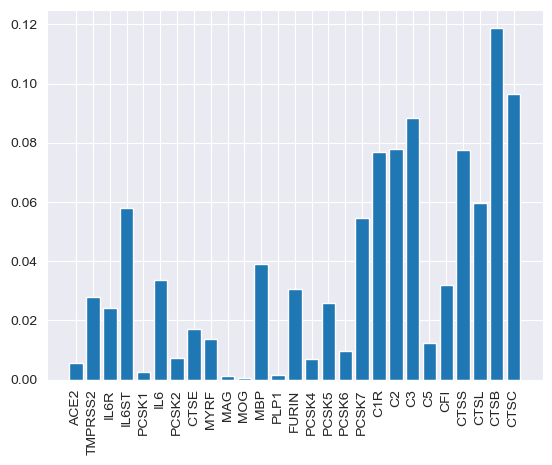

In [24]:
data = {"Importance": rf_model.feature_importances_}
#pd.DataFrame(data=data, index=adata_smkr.var_names).sort_values(by="Importance", ascending=False)
plt.bar(adata_smkr.var_names, rf_model.feature_importances_)
plt.xticks(rotation=90)

array([[0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 5., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 7., 0.],
       [0., 0., 0., ..., 0., 5., 1.],
       [0., 0., 1., ..., 1., 1., 0.]], dtype=float32)